## Multiple dispatch
Until now, we have, in our examples, defined only functions with a single method having unconstrained argument types. 

Such functions behave just like they would in traditional dynamically typed languages. Nevertheless, we have used multiple dispatch and methods almost continually without being aware of it: all of Julia's standard functions and operators have many methods defining their behavior over various possible combinations of argument type and count.

This is known as multiple dispatch!

When defining a function, one can optionally constrain the types of parameters it is applicable to, using the `::` type-assertion operator

In [1]:
function myfunc(x::Float64, y::Float64) 
    2x + y
end

myfunc (generic function with 1 method)

This function definition applies only to calls where `x` and `y` are both values of type `Float64`

Applying it to any other types of arguments will result in a `MethodError`.

In [2]:
myfunc(2,2)

LoadError: MethodError: no method matching myfunc(::Int64, ::Int64)

In [3]:
myfunc(2.0,2.0)

6.0

The arguments must be precisely of type `Float64`. Other numeric types, such as integers or 32-bit floating-point values, are not automatically converted to 64-bit floating-point, nor are strings parsed as numbers. 

Because `Float64` is a concrete type and concrete types cannot be subclassed in Julia, such a definition can only be applied to arguments that are exactly of type `Float64`. 

It may often be useful, however, to write more general methods where the declared parameter types are abstract:

In [4]:
function myfunc(x::Number, y::Number)
    2x + y
end

myfunc (generic function with 2 methods)

In [5]:
myfunc(2.0, 3)

7.0

You can easily see which methods exist for a function by entering the function object itself in an interactive session:

In [6]:
myfunc

myfunc (generic function with 2 methods)

This output tells us that `myfunc` is a function object with two methods. To find out what the signatures of those methods are, use the `methods()` function:

In [7]:
methods(myfunc)

# 2 methods for generic function "myfunc":
[1] myfunc(x::Float64, y::Float64) in Main at In[1]:1
[2] myfunc(x::Number, y::Number) in Main at In[4]:1

# Types

So far we have only worked with the basic types, `Real`s, `Integer`s, `Bool`s, `String`s and so on. We can also define our own types, which are constructed out of these base types.

Together with multiple dispatch, custom types are a very powerful features. Object oriented programming uses dynamic dispatch, where the method called depends on the type of the object. In Julia, the method can depend on the types of several arguments.

In [8]:
# This is how you define a custom type:

mutable struct MyInt
    number::Integer
end

In [9]:
# A new MyInt-object is constructed like this:

myint = MyInt(5)

MyInt(5)

In [10]:
# And we can access the number inside as

myint.number

5

The myfunc function does not have a method for MyInt, so the following will not work:

In [11]:
myfunc(myint, 5)

LoadError: MethodError: no method matching myfunc(::MyInt, ::Int64)
[0mClosest candidates are:
[0m  myfunc([91m::Number[39m, ::Number) at In[4]:1

But we can define the method to do what ever is we this is approriate.

In [14]:
"Since MyInt is better than a standard Number, multiply it by 3"
function myfunc(x::MyInt, y::Number)
    3*2*x.number + y
end

myfunc (generic function with 3 methods)

In [15]:
myfunc(myint, 5)

35

### @enum

Here is a quick way of creating a new type with a small number of possible values.

In [16]:
@enum Fruit orange banana apple pineaple lemon

The new type is called `Fruit`. An object of type Fruit can only be one of the listed things.

## The Simulation

Let's get back to our original goal. Our simulation works, but it is not quite satisfactory. The infected cells just stay infected forever, and this is not at all realistic. The cell needs to be a bit more complicated and have a state.

In [17]:
"Enumerate possible states of a single cell"
@enum InfectionStatus uninfected infected dead recovered immune

In [18]:
"Data structure containing the infection status of a cell"
mutable struct Cell
    status::InfectionStatus
    infection_time::Int8
end

Cell

Now the cells can be in one of five states. We will use the infection time variable to count the time steps the cell has been infected. After some number of steps, the cell will recover.

Immune cells never get infected. We will also add a small chance that an infected cell dies each turn and a small reinfection rate.

Let's create a second struct for these parameters:

In [19]:
"Parameters for a simulation"
mutable struct Parameters
    infection_rate::Float32
    reinfection_rate::Float32
    death_probability::Float32
    recovery_time::Int8
    immunity_rate::Float32
end

"Fast spread with low lethality and high immunity rate"
parameters = Parameters(0.2, 0.001, 0.02, 8, 0.1)

parameters

Now the array of cells holds Cell type variables instead of just integers. Creating the cells is a bit more complicated, but not horrible.

In [27]:
# Create an array of cells, with each cell undefined at first
cells = Array{Cell}(undef, 32, 32)

# Now loop over the positions in the array and create either an
# uninfected cell or an immune cell
for i in 1:size(cells)[1]
    for j in 1:size(cells)[2]
        if rand(1)[1] < parameters.immunity_rate
            cells[i,j] = Cell(immune, 0)
        else
            cells[i,j] = Cell(uninfected, 0)
        end
    end
end

# Infect one cell at the start
cells[16,16].status = infected

32×32 Matrix{Cell}:
 Cell(uninfected, 0)  Cell(uninfected, 0)  …  Cell(uninfected, 0)
 Cell(uninfected, 0)  Cell(uninfected, 0)     Cell(immune, 0)
 Cell(uninfected, 0)  Cell(uninfected, 0)     Cell(uninfected, 0)
 Cell(uninfected, 0)  Cell(uninfected, 0)     Cell(uninfected, 0)
 Cell(uninfected, 0)  Cell(uninfected, 0)     Cell(uninfected, 0)
 Cell(uninfected, 0)  Cell(uninfected, 0)  …  Cell(uninfected, 0)
 Cell(uninfected, 0)  Cell(uninfected, 0)     Cell(uninfected, 0)
 Cell(uninfected, 0)  Cell(uninfected, 0)     Cell(uninfected, 0)
 Cell(immune, 0)      Cell(uninfected, 0)     Cell(uninfected, 0)
 Cell(immune, 0)      Cell(uninfected, 0)     Cell(uninfected, 0)
 Cell(uninfected, 0)  Cell(uninfected, 0)  …  Cell(uninfected, 0)
 Cell(uninfected, 0)  Cell(uninfected, 0)     Cell(uninfected, 0)
 Cell(uninfected, 0)  Cell(uninfected, 0)     Cell(uninfected, 0)
 ⋮                                         ⋱  
 Cell(uninfected, 0)  Cell(uninfected, 0)  …  Cell(uninfected, 0)
 Cell(uninfec

Now we need to reimplement each of the simulation methods for this type. These are similar to what we had previously, but there are more possible cell types and possible interactions.

In [46]:
"""
Run the interaction between one cell and a neighbour.

If the neighbour is infected, it infect this cell with the propability
parameters.infection_rate or, if this cell is recovered, parameters.reinfection_rate.
"""
function interact!(new_cell::Cell, other_cell::Cell, parameters::Parameters)
    if new_cell.status == uninfected && other_cell.status == infected
        if rand(1)[1] < parameters.infection_rate
            new_cell.status = infected
            new_cell.infection_time = 0
        end
    end
    if new_cell.status == recovered && other_cell.status == infected
        if rand(1)[1] < parameters.reinfection_rate
            new_cell.status = infected
            new_cell.infection_time = 0
        end
    end
end

"""
Update a single cell, not accounting for it's interactions with the neighbours.
"""
function update!(new_cell::Cell, parameters::Parameters)
    if new_cell.status == infected
        new_cell.infection_time += 1
        if new_cell.infection_time > parameters.recovery_time
            new_cell.status = recovered
        end
        if rand(1)[1] < parameters.death_probability
            new_cell.status = dead
        end
    end
end

"""
Update the cells in the 2D array of Cells, using given parameters.
"""
function update!(cells::Matrix{Cell}, parameters::Parameters)
    old_cells = deepcopy(cells)
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]
            update!(cells[i,j], parameters)
        end
    end
    for i in 1:size(cells)[1]-1
        for j in 1:size(cells)[2]
            interact!(cells[i,j], old_cells[i+1,j], parameters)
            interact!(cells[i+1,j], old_cells[i,j], parameters)
        end
    end
    for i in 1:size(cells)[1]
        for j in 1:size(cells)[2]-1
            interact!(cells[i,j], old_cells[i,j+1], parameters)
            interact!(cells[i,j+1], old_cells[i,j], parameters)
        end
    end
end

update!

We can still just print out the array, but this is not pretty. Instead, let's map each cell type to a color, like we did in the plotting section.

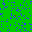

In [47]:
using Plots
using Colors

"Map the cells to colors for plotting"
function to_colors(cell::Cell)
    if cell.status == uninfected
        return RGB(0.0,0.8,0.0)
    end
    if cell.status == immune
        return RGB(0.2,0.2,1.0)
    end
    if cell.status == infected
        return RGB(0.8,0.0,0.0)
    end
    if cell.status == dead
        return RGB(0.1,0.1,0.1)
    end
    if cell.status == recovered
        return RGB(0.0,0.0,0.8)
    end
end

to_colors.(cells)

That looks pretty good! Running updates is as easy as before:

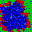

In [102]:
update!(cells, parameters)
to_colors.(cells)

Nice! The last thing we are missing is a nice animation, like we wrote in the plotting section. Do you have an idea how to do that? See the exercises for some hints.